# Data Ingestion

## Copy CSV files to S3

In [1]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


In [2]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [3]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"
s3_public_path_cities = "s3://ads508team5/cities"

# Destination Data:
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)


# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"
!aws s3 cp --recursive $s3_public_path_cities/ $s3_private_path_cities/ --exclude "*" --include "uscities.csv"

                           PRE cities/
                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/nyt/nyt-comments-2020.csv
copy: s3://ads508team5/cities/uscities.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/cities/uscities.csv


## Create Database, Tables and Parquets
### Database

In [4]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

#!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [5]:

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create Connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [6]:
# Create Database
database_name = "dbpoliticpulsecomment"

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


,database_name
0,dbpoliticpulsecomment
1,default


In [7]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [8]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


""


In [9]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,None,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,00:01.6


In [10]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


""


In [11]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter
4,uscities


In [12]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


In [13]:
# Create uscities table
table_name = "uscities"
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    city VARCHAR(45),
    state_id VARCHAR(2),
    state_name VARCHAR(30)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, table_name, s3_private_path_cities
)

pd.read_sql(statement, conn)

#with conn.cursor() as cursor:
#    for _, row in df_city.iterrows():
#        cursor.execute("INSERT INTO {}.{} VALUES ('{}', '{}', '{}')".format(database_name, table_name, row['city'], row['state_id'], row['state_name']))


""


### Parquets
#### Feature Selection and Creation
Prior creating a parquet table, tweeter and NYT comment tables are going to be combined under Comment Table in Athena where a feature creation is going to be performed. When the table is combined, we selected some features that would be benefit to our goal.

Selected features which could help on train the model are comment_id, comment_body, user_id, user_location, candidatepoll

In [14]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    u.state_id AS user_state,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(user_location) = lower(u.city) OR 
    lower(user_location) = lower(u.state_name) OR 
    lower(user_location) = lower(u.state_id)
WHERE
    LENGTH(tweet) > 3
UNION
SELECT DISTINCT
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    u.state_id as user_state,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(userLocation) = lower(u.city) OR 
    lower(userLocation) = lower(u.state_name) OR 
    lower(userLocation) = lower(u.state_id)
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

,rows


In [15]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,110811792.0,Joe Biden’s Climate Team Actually Cares About ...,70773801,Nreb,La La Land,2020-12-29 22:18:22,0,0,nyt_comment,0,1,Biden
1,108906088.0,Joe Biden should enjoy the attention from the ...,131853168,JP,ATX,2020-09-01 02:53:40,0,1,nyt_comment,1,1,None
2,108747888.0,Joe Biden is really likeable.,47215913,Technic Ally,Toronto,2020-08-21 14:45:49,0,7,nyt_comment,0,1,Biden
3,108744816.0,Joe Biden was lackluster at best as he struggl...,91525777,Backwater Sage,Florida,2020-08-21 12:08:44,3,2,nyt_comment,0,1,Biden
4,108745368.0,Joe Biden represents what is good and right wi...,65597270,Marilyn,Columbus,2020-08-21 12:41:22,0,2,nyt_comment,0,2,Biden


In [16]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [17]:
# SQL statement to execute (remove comment_id, user_name,)
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT DISTINCT user_location,
         user_state,
         comment_body,
         source,
         candidatepoll
FROM {}.{}
where candidatepoll is not null AND Length(comment_body)>1 AND length(user_location)>1""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)

,rows


In [18]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

""


In [19]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,candidatepoll=Biden
1,candidatepoll=__HIVE_DEFAULT_PARTITION__
2,candidatepoll=Trump


In [20]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter
4,uscities


In [21]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.323875e+18,None,None,"""WIN = trump https://t.co/v4yRMK4rrX",NaN,None,tweet,1,0,Trump
1,1.322214e+18,None,None,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",NaN,None,tweet,1,0,Trump
2,1.322214e+18,None,None,"""@BrettFavre @realDonaldTrump Principle’s are ...",NaN,None,tweet,1,0,Trump
3,1.322215e+18,2338690820.0,2626.0,"""Anything Trump can do",2.0,None,tweet,1,0,Trump
4,1.322215e+18,None,None,"""Trump is winning.",NaN,None,tweet,1,0,Trump


## Query Data

In [22]:
# Setup and check pre-requisites to create Database

#!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

In [23]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [24]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

#"user_state", 


In [25]:
df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])
#df_parquet_results_trump = df_parquet_results.dropna(subset = ['user_state'])
#df_parquet_results_trump = df_parquet_results[df_parquet_results['user_state'] != ' V']
df_parquet_results_trump.shape
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""WIN = trump https://t.co/v4yRMK4rrX",tweet,<NA>,Trump
1,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",tweet,<NA>,Trump
2,"""@BrettFavre @realDonaldTrump Principle’s are ...",tweet,<NA>,Trump
3,"""Anything Trump can do",tweet,2626.0,Trump
4,"""Trump is winning.",tweet,<NA>,Trump


In [26]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)

# "user_state",
df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden


# Data Exploration before Any Feature Transformation

In [27]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926684 entries, 0 to 333283
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   926684 non-null  string  
 1   source         926684 non-null  string  
 2   user_location  734725 non-null  string  
 3   candidatepoll  926684 non-null  category
dtypes: category(1), string(3)
memory usage: 29.2 MB


In [28]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434926 entries, 0 to 163918
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   434926 non-null  string  
 1   source         434926 non-null  string  
 2   user_location  309555 non-null  string  
 3   candidatepoll  434926 non-null  category
dtypes: category(1), string(3)
memory usage: 13.7 MB


In [29]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


tweet          534174
nyt_comment    392510
Name: source, dtype: Int64

In [30]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

tweet          373106
nyt_comment     61820
Name: source, dtype: Int64

In [31]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                                  64393
NYC                               13502
California                        11827
New York                          11436
USA                                8575
                                  ...  
2009-04-19 18:48:16                   1
 sleep fan                            1
Member Of The Resistance              1
 ma religion aimer"                   1
Batna                                 1
Name: user_location, Length: 94255, dtype: Int64

In [32]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

                 64393
NYC              13502
California       11827
New York         11436
USA               8575
Chicago           6948
Los Angeles       6684
NY                6620
San Francisco     6229
Seattle           6036
Florida           5700
NJ                5522
Boston            5312
United States     4949
New York City     4227
Canada            4204
New Jersey        3986
Colorado          3781
Brooklyn          3735
Texas             3713
CA                3478
Philadelphia      3155
Massachusetts     2763
Oregon            2756
Virginia          2723
Atlanta           2689
San Diego         2525
NC                2393
Maryland          2391
Midwest           2297
Name: user_location, dtype: Int64

In [33]:
df_parquet_results_biden['user_location'].value_counts()

                                               49138
United States                                   3483
New York                                        2485
NYC                                             2395
USA                                             2281
                                               ...  
Private Sector Sales & Marketing Consulting        1
2009-03-02 17:27:55                                1
1590.0                                             1
2012-01-01 19:27:49                                1
2009-10-24 20:18:05                                1
Name: user_location, Length: 73592, dtype: Int64

In [34]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

                 49138
United States     3483
New York          2485
NYC               2395
USA               2281
California        1806
NY                1298
"Los Angeles      1229
"New York         1223
Chicago           1140
Los Angeles       1088
San Francisco     1085
Seattle            982
Florida            982
"California        969
Boston             847
"Washington        793
NJ                 790
Texas              760
Virginia           759
Canada             718
"Florida           716
New York City      711
New Jersey         672
Brooklyn           630
"London            611
CA                 575
Colorado           560
Earth              558
"Texas             556
Name: user_location, dtype: Int64

# Create EDA Overview Data Visualization

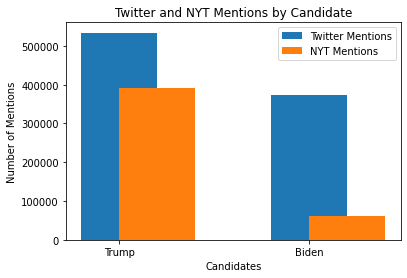

In [35]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

## Standardizing Text Entries and Location Data

In [ ]:
!pip install emoji

In [ ]:
import re
import emoji

# Function to preprocess text data
def preprocess_text(text):
    # Remove extra spaces while preserving at least one space between words
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace emojis with text labels
    text = emoji.demojize(text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove "#" from hashtags
    text = re.sub(r'#', '', text)
    # Remove "@" from mentions
    text = re.sub(r'@', '', text)
    # Check if the text consists only of numbers
    if text.isdigit():
        text = "NA"
    return text

# Apply preprocessing to text columns in the dataframe
df_parquet_results_biden['clean_text'] = df_parquet_results_biden['comment_body'].apply(preprocess_text)
df_parquet_results_biden['clean_location'] = df_parquet_results_biden['user_location'].apply(preprocess_text)
df_parquet_results_trump['clean_text'] = df_parquet_results_trump['comment_body'].apply(preprocess_text)
df_parquet_results_trump['clean_location'] = df_parquet_results_trump['user_location'].apply(preprocess_text)

# Word Clouds with Comment Body Text

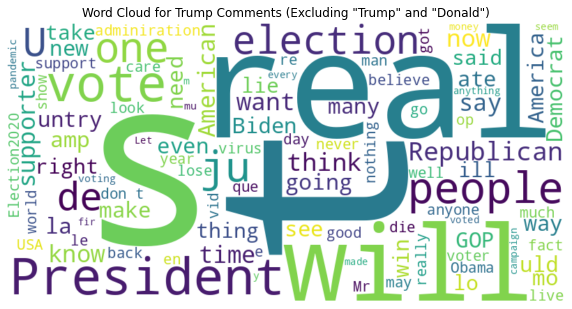

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['clean_text'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

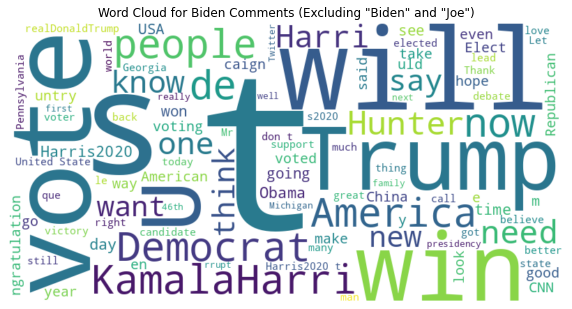

In [37]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['clean_text'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Feature Transformation and Data Cleaning

### Sentiment Labels Using Textblob and Stripping Out Non-English Text Entries with Fasttext.

### This code must be ran on Mac/Linux only. Windows is not compatible. Clean data from this code is stored in an S3 bucket and called below.

In [38]:
#pip install langdetect

In [39]:
#pip install fasttext-wheel

In [40]:
#Use pretrained model
#!pip install textblob
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P /ADS508_GroupProject
!ls -p /ADS508_GroupProject


In [41]:
!wget --no-check-certificate https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
!mkdir -p /ADS508_GroupProject

In [42]:
#import fasttext
#from textblob import TextBlob

# Load the pre-trained language identification model
model_path = '/ADS508_GroupProject/lid.176.bin'  # Path to the pre-trained language identification model
model = fasttext.load_model(model_path)

In [43]:
# Function to detect language using FastText
def detect_language_fasttext(text):
    prediction = model.predict(text)
    language_code = prediction[0][0].split('__label__')[1]
    return language_code

# Function to analyze tweet sentiment to catch non english words
def analyze_tweet_sentiment(tweet_text):
    try:
        language = detect_language_fasttext(tweet_text)
        if language == 'en':
            analysis = TextBlob(tweet_text)
            return analysis.sentiment.polarity
        else:
            return None
    except:
        return None



In [44]:
# Apply sentiment analysis to Trump data
if __name__ == "__main__":
    
    df_parquet_results_trump['sentiment'] = df_parquet_results_trump['clean_text'].apply(analyze_tweet_sentiment)
    
    # Drop non-English tweets (NaN sentiment_score)
    df_parquet_results_trump.dropna(subset=['sentiment'], inplace=True)

In [45]:
# Biden 
df_parquet_results_biden['sentiment'] = df_parquet_results_biden['clean_text'].apply(analyze_tweet_sentiment)
    
# Count NaN values before dropping
num_nans_before_biden = df_parquet_results_biden['sentiment'].isna().sum()

# Drop non-English tweets (NaN sentiment_score)
df_parquet_results_biden.dropna(subset=['sentiment'], inplace=True)

In [46]:
# Code from ChatGPT
#!pip install textblob
#from textblob import TextBlob

#def analyze_tweet_sentiment(tweet_text):
    #analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    #return analysis.sentiment.polarity


In [47]:
#Apply sentiment labels to Trump Data
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    #df_tweets_trump = df_parquet_results_trump[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']



In [48]:
 # Apply Sentiment labels to Biden Data       
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    #df_tweets_biden = df_parquet_results_biden[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


## Combine candidate data

In [49]:
df_combined = pd.concat([df_parquet_results_biden, df_parquet_results_trump], ignore_index=True)

### Create sentiment labels

In [50]:
df_combined['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else 'neutral'))

# Upload clean language dataset as S3 bucket. Once this step is completed, this can be commented out, and data can be called in subsequent code block.

In [51]:
#import boto3

# Specify the S3 bucket name
bucket_name = '508group'  

# Specify the file name in S3
file_name = 'df_combined.csv'

# Write DataFrame to a CSV file
df_combined.to_csv(file_name, index=False)

# Create an S3 client
s3 = boto3.client('s3')

# Upload CSV file to S3
with open(file_name, "rb") as f:
    s3.upload_fileobj(f, bucket_name, file_name)

print(f"DataFrame saved as {file_name} in S3 bucket: {bucket_name}")

# Import clean language dataset from S3 bucket

In [4]:
# Specify the S3 bucket name
bucket_name = '508group'  

# Specify the file name in S3
file_name = 'df_combined.csv'

# Create an S3 client
s3 = boto3.client('s3')

# Generate the URL for the file in S3
file_url = f's3://{bucket_name}/{file_name}'

# Read the CSV file directly into a DataFrame
df_combined = pd.read_csv(file_url)


In [5]:
df_combined.head()

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,0.00,neutral
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,NaN,Biden,0.33,positive
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,NaN,Biden,0.00,neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,0.00,neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,0.00,neutral


In [7]:
df_combined.shape

(1191124, 6)

# Additional EDA with Clean Language Data

## Trump Data

In [55]:
# Examine Trump Sentiment distribution
df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'].value_counts()

 0.000000    356570
 0.500000     26114
 0.200000     17016
 0.250000     15715
 0.100000     13370
              ...  
 0.335303         1
-0.086035         1
-0.132500         1
 0.168019         1
-0.075284         1
Name: sentiment, Length: 20374, dtype: int64

In [56]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] < 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
365444,Total LOSER @POTUS @realDonaldTrump @FLOTUS @E...,tweet,France,Trump,-0.250000,negative
365446,"""@realDonaldTrump is a disgrace. Trump is not ...",tweet,NaN,Trump,-0.250000,negative
365448,"""I hope they refuse to move into the White Hou...",tweet,NaN,Trump,-0.016667,negative
365449,"""#Trump has not gained as much as one big elec...",tweet,97.0,Trump,-0.033333,negative
365451,"""@matteosalvinimi @realDonaldTrump ... Black F...",tweet,NaN,Trump,-0.166667,negative


In [57]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] == 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
365440,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump,0.0,neutral
365442,"""#ByeByeTrump you are gefeuert..",tweet,NaN,Trump,0.0,neutral
365445,"""Trump: """"Uncle! Uncle!""""",tweet,NaN,Trump,0.0,neutral
365447,"""Remember Trumps' 2016 election was a lot abou...",tweet,NaN,Trump,0.0,neutral
365450,"""Dear #DonaldTRump - You're Fired!",tweet,NaN,Trump,0.0,neutral


In [58]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] > 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
365441,"""Finally a real president! Trump supporters",tweet,NaN,Trump,0.250000,positive
365443,"""Trump be like : accha main chlta hu duao main...",tweet,NaN,Trump,0.166667,positive
365460,Hope we Europeans wake up to good news tomorro...,tweet,Norway,Trump,0.700000,positive
365469,"""@guardian Sad to see. The only way @realDonal...",tweet,NaN,Trump,0.200000,positive
365476,"""#Trump was big on symbols and liked to appear...",tweet,NaN,Trump,0.070370,positive


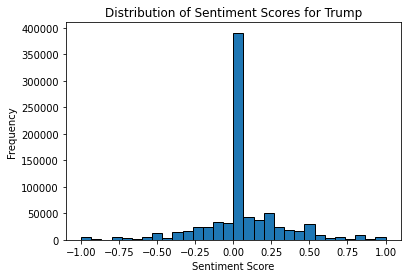

In [59]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

### Biden Data

In [60]:
df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'].value_counts()

 0.000000    192974
 0.500000     11775
 0.800000      7973
 0.250000      6450
 0.300000      6058
              ...  
-0.205455         1
 0.278889         1
 0.078750         1
 0.083168         1
-0.012240         1
Name: sentiment, Length: 9386, dtype: int64

In [61]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] < 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
17,"""The only people stupid enough to believe #Joe...",tweet,NaN,Biden,-0.175,negative
39,The evil has been vanquished. #JoeBiden #JOEBI...,tweet,2009-07-11 02:11:26,Biden,-1.000,negative
74,Trumps just making baseless claims and it’s sa...,tweet,2020-10-30 01:10:30,Biden,-0.500,negative
79,#joebiden has plans for a path forward to the ...,tweet,concerned global citizen,Biden,-0.125,negative
96,oh shit i just realized i must tell my crush t...,tweet,"""Donna",Biden,-0.200,negative


In [62]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] == 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,0.0,neutral
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,NaN,Biden,0.0,neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,0.0,neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,0.0,neutral
6,#biden #potus #PresidentElectJoe #PresidentEle...,tweet,NaN,Biden,0.0,neutral


In [63]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] > 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,NaN,Biden,0.33,positive
5,Joe Biden is the best thing that happened in 2...,tweet,NaN,Biden,1.00,positive
7,This will really sting the orange toady. World...,tweet,135.0,Biden,0.20,positive
10,"""I hope the first thing @BarackObama said to @...",tweet,"preppy-goth-hippie.""",Biden,0.25,positive
11,"""happy with the triumph of JOE BIDEN",tweet,"3016159752 Y 3145304871""",Biden,0.80,positive


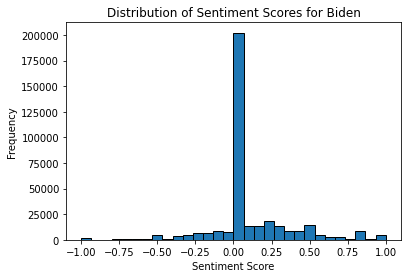

In [64]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Data Source Proportions with Clean Data

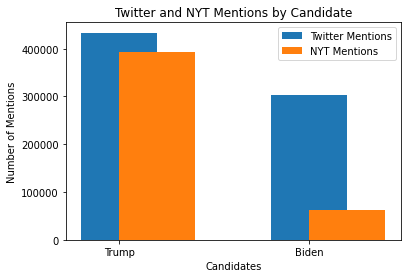

In [65]:
candidate = ['Trump','Biden']
twitter_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[0], 
             df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[0]]
nyt_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[1], 
         df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

# Additional Feature Engineering

## Create Outcome Variable

In [6]:
df_combined['SentimentOutcome'] = df_combined['candidatepoll']+"_"+df_combined['sentiment_category']

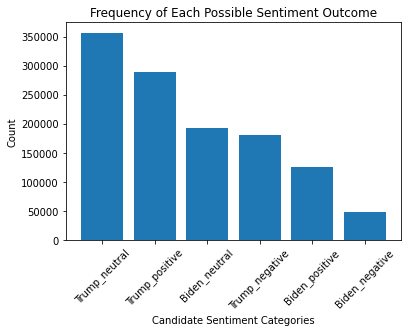

In [7]:
import matplotlib.pyplot as plt
category_counts = df_combined['SentimentOutcome'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Candidate Sentiment Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.ylabel('Count')
plt.title('Frequency of Each Possible Sentiment Outcome')
plt.show()

## Smallest category is Biden_negative. Check number. When using train/test/split with 90/5/5 ratio, we will have to balance categories to observationse each based on 90% of the smallest category.

In [8]:
 df_combined[df_combined['candidatepoll'] == 'Biden']['SentimentOutcome'].value_counts()

Biden_neutral     192974
Biden_positive    124559
Biden_negative     47907
Name: SentimentOutcome, dtype: int64

In [9]:
 df_combined[df_combined['candidatepoll'] == 'Trump']['SentimentOutcome'].value_counts()

Trump_neutral     356570
Trump_positive    289203
Trump_negative    179911
Name: SentimentOutcome, dtype: int64

## Mapping Location Data and Map EDA. NEED TO TROUBLESHOOT THIS STILL.

In [ ]:
# Read csv US City from S3 ---> PLANNING TO MOVE IT IN .py AND USE PREPROCESSING JOB FROM SAGEMAKER
git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
df_city = pd.read_csv(git_city_loc)

df_combined['clean_location'].head(5)

In [ ]:
# PREFER TO RUN IT IN .py with SageMaker processing job
# TRY IT WITH 100 RECORD ONLY


# Create master location table
master_location = df_city
df_combined = df_combined.head(100)

# Function to map city and state name to state ID
def map_state_id(city):
    for index, loc in master_location.iterrows():
        if city.lower() == loc['city'].lower() or city.lower() == loc['state_name'].lower():
            return loc['state_id']
    return None

# Apply mapping function to user location table
df_combined['final_location'] = df_combined['clean_location'].apply(map_state_id)  # Use clean location data from primary cleaning step

# Display the user location table with State ID column added

In [31]:
# Data Vis
# # creat colored maps by state based on sentiment

In [ ]:
# Determime sample size from each state

In [ ]:
# Determine portion of Trump/Biden for each state

# Data Partition

### Assign input and outcome variables

In [10]:
# Update to 'clean_text' for X after rerunning sentiment and location data
X = df_combined[['comment_body']]  # Add location back in later
y = df_combined['SentimentOutcome']

### Create a 90/5/5 data split

In [11]:
from sklearn.model_selection import train_test_split

# Split data into 90% train and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Split remaining data (90% train) into 90% train and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=1)

### Further undersample the training set so that each level of the outcome variable is equal

In [12]:
#!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

# Undersample the training set to balance the six categorical outcome levels
undersampler = RandomUnderSampler(sampling_strategy='all', random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

## Verify split datasets size

In [13]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230340 entries, 129005 to 377157
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_body  230340 non-null  object
dtypes: object(1)
memory usage: 3.5+ MB


In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119113 entries, 853897 to 606574
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_body  119113 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [15]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119113 entries, 269675 to 443854
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_body  119113 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [16]:
X_train_resampled.shape, X_test.shape, X_val.shape

((230340, 1), (119113, 1), (119113, 1))

In [17]:
X_train_resampled.head()

,comment_body
129005,'#SNL' host #DaveChappelle urges #Biden voters...
227771,America will be in far worse shape by January ...
65243,@oliverdarcy @BretBaier You're out of your min...
252276,The VP was running behind schedule so his Secr...
31151,"""@ScorpioOfficial @EVerastegui @Scaramucci @Jo..."


In [18]:
X_test.head()

,comment_body
853897,@Nancy Americans of all persuasions need to ke...
553832,Oh - being MEAN to #Trump. @Yamiche 👀👇 https:/...
238034,"""""""an equal share of very conservative voters ..."
533908,@kenneth he thought maybe they'd come to their...
521614,"""So you ... obviously are NOT tired of ... #tr..."


In [19]:
X_val.head()

,comment_body
269675,@Juan Garcia I agree. This election was very i...
76636,"4 states suddenly """"found"""" ballots--over 100..."
998763,"""You a relative of #Trump"
998584,The margins between #Trump and #Biden are subs...
209880,VOTE FOR @JoeBiden !! #JoeBiden #2020Election ...


## Verify balance of training set

In [20]:
y_train_resampled.value_counts()

Biden_negative    38390
Biden_neutral     38390
Trump_neutral     38390
Trump_negative    38390
Biden_positive    38390
Trump_positive    38390
Name: SentimentOutcome, dtype: int64

## Average length of comments. Limit word vectors to median length of 15.

In [21]:
# Function to count string word length
def count_word_length(text):
    words = text.split()
    return len(words)

# Add column to DataFrame
df_combined['word_length'] = df_combined['comment_body'].apply(lambda x: count_word_length(x))  # Update to clean_text

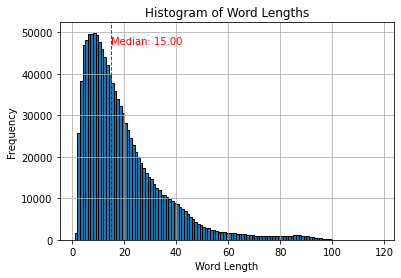

In [22]:
import numpy as np
median_word_length = np.median(df_combined['word_length'])

# Plot histogram of word lengths
plt.hist(df_combined['word_length'], bins=range(min(df_combined['word_length']), max(df_combined['word_length']) + 1), edgecolor='black')
plt.axvline(median_word_length, color='red', linestyle='dashed', linewidth=1)  # Add vertical line at median
plt.text(median_word_length, plt.ylim()[1] * 0.9, f'Median: {median_word_length:.2f}', color='red')  # Add label for median
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.grid(True)
plt.show()

# Text Entry Preprocessing and Data Transformation Pipeline: Will Need to Add Categorical One-Hot Encoding if we use Location Data

In [23]:
#!pip install gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec

# Define custom transformer for Word2Vec embeddings
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_count=1, workers=4):
        self.word2vec_model = Word2Vec(window=window, min_count=min_count, workers=workers)
    
    def fit(self, X, y=None):
        # Train Word2Vec model
        X_word_lists = [text.split()[:15] for text in X]  # Limit to first 15 words
        self.word2vec_model.build_vocab(X_word_lists)
        self.word2vec_model.train(X_word_lists, total_examples=len(X_word_lists), epochs=10)
        return self
    
    def transform(self, X):
        # Limit text to first 15 words and split into word lists
        X_word_lists = [text.split()[:15] for text in X]
        # Initialize a list to store word embeddings
        embeddings = []
        # Iterate over each word list
        for word_list in X_word_lists:
            # Initialize a list to store word embeddings for this word list
            word_embeddings = []
            # Iterate over each word in the word list
            for word in word_list:
                # Check if the word exists in the Word2Vec model's vocabulary
                if word in self.word2vec_model.wv:
                    # Retrieve the word embedding and append it to the list
                    word_embeddings.append(self.word2vec_model.wv[word])
                else:
                    # If the word doesn't exist in the vocabulary, append zeros
                    word_embeddings.append([0] * self.word2vec_model.vector_size)
            # Append the word embeddings for this word list to the embeddings list
            embeddings.append(word_embeddings)
        return embeddings

# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('word2vec', Word2VecTransformer())
])

In [24]:
# Fit and transform on the training set
X_train_transformed = pd.DataFrame(preprocessing_pipeline.fit_transform(X_train_resampled['comment_body']))  # Update to clean_text

In [25]:
X_test_transformed = pd.DataFrame(preprocessing_pipeline.transform(X_test['comment_body']))  # Update to clean_text

In [26]:
X_val_transformed = pd.DataFrame(preprocessing_pipeline.transform(X_val['comment_body']))  # Update to clean_text

In [27]:
X_train_transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"[0.035225447, -0.059765726, 0.027737321, -0.01...","[-0.56956905, 0.032301664, -0.21336614, -0.185...","[0.032303967, -0.06844695, 0.059938505, -0.094...","[0.21293703, 0.27289352, 0.26022956, -0.308363...","[-2.4274979, -2.5757635, -1.2896038, 0.7923052...","[-2.0452254, 0.05736883, -0.81172335, -1.86572...","[-4.1848893, -0.28573638, 0.85454565, -0.92413...","[-1.7041054, -5.0627937, -3.1543655, -2.964932...","[0.03439471, 0.010229139, 0.05096185, -0.05622...","[0.056908637, 0.14968282, -0.05712866, -0.1514...","[0.23912153, -0.19771758, 0.7784201, -0.131993...","[0.0066250544, -0.0062153754, 0.03446674, -0.0...",None,None,None
1,"[-3.0819533, -0.4436668, -2.3144743, -3.621958...","[-2.6440108, -0.3774276, -0.12937427, -1.62455...","[-1.7041054, -5.0627937, -3.1543655, -2.964932...","[-4.413952, 2.6746764, -0.11531685, 2.242517, ...","[-0.74731624, 1.0050492, -2.9754562, -0.581712...","[0.106325336, 2.0461, -4.4842386, -1.6360177, ...","[-0.23578376, -0.10682246, -0.28834262, -0.075...","[1.9650167, -0.39345068, 0.591088, -2.8486335,...","[-0.9054813, -0.98949856, -1.2604121, -1.17916...","[-0.9259401, -0.69535017, -1.4252279, 0.345289...","[-3.9453678, 1.0171343, -0.022832239, -5.36047...","[-3.3487892, 1.1536659, -1.203971, -0.4235816,...","[-1.5643464, 1.5031286, -1.3488846, -2.3585298...","[-0.63671625, -0.46176788, -3.0663362, -0.6533...","[-0.16891174, 0.032068003, 0.11560726, -0.3628..."
2,"[-0.0016643116, 0.09925733, 0.06469199, 0.0042...","[0.29044208, 0.10145254, 0.06357661, -0.076809...","[0.540113, -0.04896608, -0.93679184, -0.405538...","[-7.4863515, -1.0237776, 0.09111458, 2.0802214...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[0.5803525, 1.3451151, 1.1254013, 3.0781825, 1...","[-0.5609624, 0.6032938, -0.1877066, -0.5453295...","[0.025319792, 0.5584455, -2.8361645, -1.362315...","[-0.16770646, 0.12130113, -0.34488586, -0.0425...","[-0.9816561, 1.910468, -4.99865, 3.3377156, 2....","[-0.3370915, 0.58126926, -2.5338023, -0.185111...","[-6.1981854, 1.5298219, -1.669842, 2.13113, 0....","[-0.9516586, -0.649275, -0.8467544, -1.1149001...","[-1.0284175, 1.0099721, 0.2510879, -1.1130205,...","[-3.3487892, 1.1536659, -1.203971, -0.4235816,..."
3,"[-1.7260661, 4.4289336, -1.2089039, 1.411353, ...","[-2.844123, -0.95696086, -3.207866, -3.117969,...","[-0.60461617, -0.78417224, -3.5690582, -0.2202...","[0.16595662, -0.5362385, -2.4361746, -2.539376...","[0.67296255, 1.5936245, 0.67774105, -0.2150728...","[-0.18646228, -0.009369312, -0.25688767, -0.01...","[-2.4246151, -1.6521384, -0.77466804, -3.59716...","[0.81378776, 0.84744954, -2.9729426, -2.178806...","[-1.1729314, 0.4777623, 0.7969604, -0.3775274,...","[-0.8684197, 0.55721074, 1.6846421, 0.00514604...","[-0.47243842, 0.010877584, 0.5679208, -0.19133...","[-4.9408784, 0.44029364, -0.70424366, -3.36297...","[-0.114878066, 0.17436452, -0.18002465, -0.246...","[-1.7772644, 1.4084659, 0.40321127, 0.31339568...","[-4.1848893, -0.28573638, 0.85454565, -0.92413..."
4,"[0.016547024, 0.015895221, 0.019524856, -0.022...","[0.0044159186, 0.029356861, 0.052184604, -0.05...","[0.3328877, 0.28842953, 0.19361645, 0.13861372...","[0.13058914, -2.2631202, -4.641016, -1.5254668...","[-0.019854078, 0.008097932, 0.07662178, -0.032...","[0.002639703, 0.025885964, 0.03619094, -0.0216...","[-0.18377946, -0.22687708, 0.17834167, -0.0314...",None,None,None,None,None,None,None,None


In [28]:
X_test_transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"[0.010399206, 0.007834569, -0.031668287, 0.062...","[-1.7854503, 0.47772512, -1.0257261, -3.255046...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[-0.758522, -0.22285382, -0.11463854, 0.575181...","[0.009196537, 0.002889895, 0.017597055, -0.023...","[-0.35786623, 1.2992178, -0.8202265, 1.3113679...","[-4.1848893, -0.28573638, 0.85454565, -0.92413...","[-0.40348133, -1.8514776, -1.0395265, -0.89081...","[0.34668213, 0.23416445, 0.1286821, -0.7573103...","[-2.4389167, -2.2011483, -0.7832999, -0.354334...","[-4.413952, 2.6746764, -0.11531685, 2.242517, ...","[-0.075966164, 0.055134594, -0.19742051, -0.01...","[-5.3785267, 1.5724504, -2.2793715, -1.4952916...","[-0.42085034, 0.8272032, 0.14135227, -0.713743...","[-4.1848893, -0.28573638, 0.85454565, -0.92413..."
1,"[-0.048115827, 0.012025292, -0.69078636, -0.06...","[-4.520925, -1.6557858, -4.2857585, -0.5679996...","[1.3837428, -1.1662371, -0.5290076, 0.00919716...","[-0.038114633, -0.032311086, 0.12439562, -0.00...","[-4.1848893, -0.28573638, 0.85454565, -0.92413...","[-0.16989325, -1.1362512, 0.60259145, -0.85037...","[0.07821221, 0.12361503, 0.17132121, -0.072046...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",None,None,None,None,None,None
2,"[-0.041132685, 0.056120176, -0.021368302, -0.0...","[-0.17941488, 0.094135635, -0.19377156, -0.106...","[-1.0117861, 1.022121, -0.11319851, 0.49867767...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[-1.3274412, -1.8430043, -2.6927247, -3.467315...","[-1.8650537, 0.7194749, -0.74125576, -0.345748...","[-2.0452254, 0.05736883, -0.81172335, -1.86572...","[-0.10496099, 0.20985742, 0.07676167, -0.18152...","[-3.8400064, -0.640603, -1.0979832, -1.8117853...","[-0.33853966, 0.48047423, -0.19613689, -0.1675...","[-0.75994074, 1.1629426, -1.9162087, 0.8411408...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[-1.2314645, 0.66691774, -0.88396597, -1.20607...","[-0.6213156, 0.3078452, -0.219414, -0.6612202,..."
3,"[0.0013461343, 0.024971806, -0.008324635, 0.02...","[-2.613385, -1.6231915, -2.743972, -2.0509741,...","[-1.7867258, 0.08436637, -2.004561, -1.1794327...","[-0.15352754, -0.39988276, -1.3842013, -0.7374...","[-0.2440196, -0.03937291, 0.2683629, -0.271659...","[-1.3763599, 0.13333729, -1.6506805, -1.275685...","[-4.1848893, -0.28573638, 0.85454565, -0.92413...","[0.22659847, -0.27928928, 0.9389232, -3.921795...","[-0.19294505, 0.05055865, -0.055762015, -0.010...","[-2.8467953, -1.5599296, -0.25707507, -2.55188...","[-1.8819073, 0.7776386, -0.16438858, -0.245796...","[-0.46701252, -0.02793532, -0.19544865, -0.170...",None,None,None
4,"[-3.249866, 0.37764886, 0.10668152, -1.6621199...","[-2.481188, -0.35665703, 1.8188795, 1.1254121,...","[-1.4619781, -0.22261643, -1.1805775, -0.12413...","[-0.42121303, 0.17074373, -1.4082049, -0.87095...","[-0.63671625, -0.46176788, -3.0663362, -0.6533...","[-0.80197936, -0.34270132, 2.0055382, 0.055282...","[0.040978838, -0.14604464, -0.4828205, -2.2520...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[-1.4619781, -0.22261643, -1.1805775, -0.12413...","[0.02052724, -0.028363464, 0.28639442, -0.0673...","[-0.029912403, 0.93835396, -2.7717042, -0.5463...",None,None,None,None


In [29]:
X_val_transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"[-0.03072511, 0.03878345, -0.028312596, -0.003...","[-0.002924499, 0.010803262, -0.034063112, 0.01...","[-0.76423335, 2.266512, -3.8561807, -3.8429954...","[-1.4607556, 0.86765957, -0.76925516, 1.188273...","[-0.17795756, 1.3812755, -3.4679432, 1.8756967...","[-4.151627, -1.5809144, 0.14911227, -2.5752957...","[-0.60461617, -0.78417224, -3.5690582, -0.2202...","[-1.3274412, -1.8430043, -2.6927247, -3.467315...","[-1.0114625, 2.250099, -1.293531, -0.22651632,...","[-2.2496922, -0.90541583, -0.7434838, 0.127442...","[-3.3487892, 1.1536659, -1.203971, -0.4235816,...","[-1.5708231, 0.20758879, -1.2369825, -1.346687...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[-2.707713, 0.6212725, -4.9616556, 2.8149498, ...","[-1.458436, 0.2451716, 0.581622, -1.3012094, 1..."
1,"[-1.5273005, -0.840494, -2.063631, 1.7336224, ...","[-3.5079615, -0.33663568, 0.307559, -0.4735137...","[-0.78300613, 0.016750725, -0.52029026, -0.328...","[-0.008790851, 0.12485781, 0.038803093, 0.0586...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02439815, 0.052341294, -0.07402564, -0.0537...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[-2.1802328, -0.54599845, 1.1584392, -3.548756...","[0.5727882, -1.5127221, -3.0884228, -6.74544, ...","[-0.75071836, 0.17501497, -0.46808323, 0.70287...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0012766471, 0.02038308, -0.04308207, 0.0400...","[1.3709183, -0.16595817, -0.61593086, -5.83130...","[-0.8071408, -1.366398, -1.2593989, 0.331444, ...","[0.30081224, -0.9161131, 1.0690383, -0.3131023..."
2,"[-1.3075161, 0.78058636, -0.021923993, -2.8696...","[-3.8400064, -0.640603, -1.0979832, -1.8117853...","[-0.49076056, -0.28917992, -0.3235581, 0.05968...","[-1.8080386, 1.7564801, -1.3733672, -1.48236, ...","[-0.49594453, -1.8244474, 1.1779295, -2.457801...",None,None,None,None,None,None,None,None,None,None
3,"[-1.7260661, 4.4289336, -1.2089039, 1.411353, ...","[-0.06876471, -0.15294124, -0.21027906, -0.027...","[-0.4989822, 4.6299186, -0.62146544, 0.3194044...","[-0.49594453, -1.8244474, 1.1779295, -2.457801...","[-4.9408784, 0.44029364, -0.70424366, -3.36297...","[-2.4274979, -2.5757635, -1.2896038, 0.7923052...","[-0.63671625, -0.46176788, -3.0663362, -0.6533...","[-0.3599693, 0.12072832, -0.15268078, -0.18677...","[-0.2768668, 1.1473571, -1.5124246, 0.11377916...","[-2.2496922, -0.90541583, -0.7434838, 0.127442...","[-3.3487892, 1.1536659, -1.203971, -0.4235816,...","[-2.6537514, 2.2415824, -3.0446289, 1.2838819,...","[-1.4207747, 0.86443967, -0.71393293, -1.27978...","[-0.07828054, 0.027086845, -0.012247973, -0.03...","[-0.56973344, 0.17012872, -0.19383843, 0.23146..."
4,"[1.3230175, -0.57802725, 2.1925292, -1.261581,...","[1.6714952, -0.57816494, 2.6243646, 0.09697516...","[0.13058914, -2.2631202, -4.641016, -1.5254668...","[0.55493355, -0.2998718, 0.5295995, 0.46967682...","[-2.9852054, -3.0564573, 0.8955924, -0.5066815...","[0.66091114, -1.006331, 2.5320008, -0.4235561,...","[1.7149355, -0.8634766, 2.4230068, 0.04538809,...","[1.6938109, -0.34626415, 1.6970623, -0.352236,...","[1.5914693, -0.7180247, 2.5982928, -0.23320867...","[0.08368754, -0.052258007, 0.23045418, -0.1025...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",None,None,None


# Store Data For Modeling in Bucket

In [ ]:
#import boto3

# Specify the S3 bucket name
bucket_name = '508group_modeling'
    
# List of DataFrame objects
dataframes = [X_train_transformed, y_train, X_test_transformed, y_test, X_val_transformed, y_val]

# List of corresponding file names
file_names = ['X_train_transformed.csv', 'y_train.csv', 'X_test_transformed.csv', 'y_test.csv', 'X_val_transformed.csv', 'y_val.csv']

# Create an S3 client
s3 = boto3.client('s3')

# Upload each file to S3
for df, file_name in zip(dataframes, file_names):
    # Write DataFrame to a CSV file
    df.to_csv(file_name, index=False)
    
    # Upload CSV file to S3
    with open(file_name, "rb") as f:
        s3.upload_fileobj(f, bucket_name, file_name)

    print(f"DataFrame saved as {file_name} in S3 bucket: {bucket_name}")

# Import Data for Modeling

In [ ]:
import boto3
import pandas as pd

# Specify the S3 bucket name
bucket_name = '508group_modeling'

# List of file names in S3
file_names = ['X_train_transformed.csv', 'y_train.csv', 'X_test_transformed.csv', 
              'y_test.csv', 'X_val_transformed.csv', 'y_val.csv']

# Create an S3 client
s3 = boto3.client('s3')

# Initialize variables to store DataFrames
X_train = None
y_train = None
X_test = None
y_test = None
X_val = None
y_val = None

# Iterate over each file name
for i, file_name in enumerate(file_names):
    # Generate the URL for the file in S3
    file_url = f's3://{bucket_name}/{file_name}'
    
    # Read the CSV file directly into a DataFrame
    df = pd.read_csv(file_url)
    
    # Assign the DataFrame to the corresponding variable based on index
    if i == 0:
        X_train = df
    elif i == 1:
        y_train = df
    elif i == 2:
        X_test = df
    elif i == 3:
        y_test = df
    elif i == 4:
        X_val = df
    elif i == 5:
        y_val = df

## Verify contents of DFs

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
X_val.head()

In [ ]:
y_val.head()

## Run Data Bias Analysis

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

In [ ]:
!aws s3 ls $bias_data_s3_uri

In [ ]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_s3_uri

In [ ]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

In [ ]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

In [ ]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

### Calculate Bias Metrics for Balanced Data

In [ ]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [ ]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [ ]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



In [ ]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


#### Download report

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

In [ ]:
_testing